# 主体框架


- 核心：围绕着是否存在仓位
- 考虑程序断连
    - 当程序处于断连状态，必须立刻有连接的操作
    - 连接保证后，再考虑是否下载数据、进行操作

初始化函数及准备
进出场条件设置
策略可视化
MPLFinance
策略执行
TWS中的错误响应问题
策略监控
时区问题
结果统计
程序修正


# 导入模块、包、类

In [1]:
from ibapi.client import EClient, HistoricalTick# , ClientException
from ibapi.order import Order
from ibapi.wrapper import EWrapper, CommissionReport, Contract
from ibapi.utils import iswrapper
from ibapi.execution import Execution, ExecutionFilter
from ibapi.account_summary_tags import AccountSummaryTags

In [2]:
import collections
from threading import Thread
import time
from datetime import datetime
import pandas as pd
import talib as ta
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf
plt.rcParams['font.sans-serif'] = ['Kaiti']
plt.rcParams['axes.unicode_minus'] = False

# 定义交易函数

## 下市价订单

In [8]:
def Place_Market_Order( Contract: Contract, Action: str, Quantity: float):
    order = Order()
    order.action  = Action
    order.totalQuantity = Quantity
    order.orderType = 'mkt'
    # order.lmtPrice = 1.15
    order.transmit = True
    
    # 获得下一个可用订单编号
    ibapi.reqIds(-1)
    time.sleep(0.5)
    
    if ibapi.nextorderId:
        ibapi.placeOrder(ibapi.nextorderId, Contract, order)
        """执行之后，响应函数为 openOrder 和 orderStatus"""
        time.sleep(2)
    else:
        print('Order ID not received. Ending application.')
        sys.exit()

## 指标计算：唐奇安通道

In [9]:
def donchian_high(df:pd.DataFrame, n:int, name:str) -> None:
    """
    作用：计算唐奇安通道的上轨
    参数：
        df 数据
        n 表示周期
        name 表示在 df 中新的列名，用来存储唐奇安通道的上轨数值
    """
    length = len(df)
    if length < n:
        print('获取数据太短，不能计算唐奇安通道')
        return 
    df['{}'.format(name)] =  np.NAN  # 初始化空数据框
    for i in range(n, length):
        df['{}'.format(name)] [i] = df['High'][i-n:i].max()

In [10]:
def donchian_low(df:pd.DataFrame, n:int, name:str) -> None:
    """
    作用：计算唐奇安通道的上轨
    参数：
        df 数据
        n 表示周期
        name 表示在 df 中新的列名，用来存储唐奇安通道的下轨数值
    """
    length = len(df)
    if length < n:
        print('获取数据太短，不能计算唐奇安通道')
        return 
    df['{}'.format(name)] =  np.NAN  # 初始化空数据框
    for i in range(n, length):
        df['{}'.format(name)] [i] = df['Low'][i-n:i].max()

## 入场出场信号

- 定义这些条件需要注意 `df[-1]` 表示当前还没有走完的一根，此根蜡烛图不在计算范围内

In [11]:
def buy_condition() -> bool:  # 做多
    if df['High'][-2] > df['donchian_up'][-2] and df['High'][-3] < df['donchian_up'][-3]:    # 比较运算符的优先级 > 逻辑与
        return True
    else:
        return False

In [12]:
def sell_condition() -> bool:  # 做空
    if df['Low'][-2] < df['donchian_down'][-2] and df['Low'][-3] > df['donchian_down'][-3]:    # 比较运算符的优先级 > 逻辑与
        return True
    else:
        return False

In [13]:
def close_buy_condition() -> bool:  # 多头平仓
    if df['Low'][-2] < df['donchian_down_n3'][-2] and df['Low'][-3] > df['donchian_down_n3'][-3]:    # 比较运算符的优先级 > 逻辑与
        return True
    else:
        return False

In [14]:
def close_sell_condition() -> bool: # 空头平仓
    if df['High'][-2] > df['donchian_up_n3'][-2] and df['High'][-3] < df['donchian_up_n3'][-3]:    # 比较运算符的优先级 > 逻辑与
        return True
    else:
        return False

## 日志记录

In [15]:
def log_to_localfile(content:str):
    current_time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    content = current_time +':'+ content
    space = '\n'
    a = open(file = 'TWS_log.txt', mode = 'a+')
    a.write(space + content + space)
    a.close()

In [16]:
def req_current_time() -> str:
    current_IDE_time = datetime.now().strftime('%H:%M:%S')  # 任务2：每秒打印时间显示
    #current_IDE_time = datetime.now().strftime('%H:%M')  # 任务2：每秒打印时间显示
    return current_IDE_time

In [17]:
def req_current_TWS_time() -> str:
    current_TWS_time = ibapi.current_TWS_time.strftime('%H:%M')
    return current_TWS_time

# IBapi 类定义

In [18]:
class IBapi(EClient, EWrapper):
    """
    需要这么几方面数据：
    # 1. 行情数据：
    当前合约的所有时间框架下的数据，需要能够得到在当前时刻的，过去n根bar数据OHLCV
    需要获取实时数据，实时tick数据，包含成交数据，以及报价数据

    2. 账户数据
    当前账户信息
    需要得到当前仓位信息，仓位放入dataframe中
    历史成交

    3. 订单管理数据
    订单发送
    当前挂单状态
    历史订单
    """
    def __init__(self, addr, port, client_id):
        posns = collections.defaultdict(list)  # 这是什么意思？

        EClient.__init__(self, self)
        self.data = []  # self.data:list 必须放置在这个位置，因为是以流形式存在
        self.historical_data_end = False  # ?
        self.current_position = [] # 自定义的属性，用于保存当前
        self.connect(addr, port, client_id)
        self.current_TWS_time = datetime.now()

        # 客户端线程
        thread = Thread(target=self.run)
        thread.start()

    @iswrapper
    def currentTime(self, cur_time):  # 返回当前时间戳：任务2√
        t = datetime.fromtimestamp(cur_time)
        print('Current time:{}'.format(t))
        self.current_TWS_time = t
    
    @iswrapper    
    def historicalData(self, reqId: int, bar):  # 获得行情数据：任务3√
        # 这里原来为何没有函数注解呢？这里不能用 bar: Bar，会报错：name 'Bar' is not defined
        # print(f'Time: {bar.date} Open:{bar.open} High: {bar.high} Low: {bar.low} Close: {bar.close}')
        self.data.append([bar.date, bar.open, bar.high, bar.low, bar.close])
            # 此函数重构了historicalData函数，响应reqhistoricalData的请求，返回reqId:int，和bar:Bar
        # Bar中包含OHLC和Volume，Volume在外汇中不好使，reqhistoricalData中使用"TRADES",这是个错误
        # 如果是股票则需要成交量，外汇暂可以认为成交量oo
        # https://interactivebrokers.github.io/tws-api/historical_bars.html  
        
    @iswrapper  
    def historicalDataEnd(self, reqId:int, start: str, end:str):   # 标记历史数据结束：任务3√
        # Marks the ending of the historical bars reception. 
        # once all candlesticks have been received the IBApi.EWrapper.historicalDataEnd marker will be sent. 
        
        self.historical_data_end = True  # 这是什么意思啊
        print('HistoricalDataEnd.ReqId:', reqId, 'from', start, 'to', end)
    
    def storehistoricalData(self):  # 任务3 √
        # 完全自定义函数，将历史数据存入 df 中
        df = pd.DataFrame(self.data, columns = ['DateTime', 'Open', 'High', 'Low', 'Close'])
        df['DateTime'] = pd.to_datetime(df['DateTime'])
        df.set_index(['DateTime'], inplace = True)
#         df.to_csv('eurusd.csv') 
        return df
        # print(df)
    
    @iswrapper
    def position(self, account: str, contract: Contract, position: float,avgCost: float):  # 返回当前仓位信息：任务5√

        """
        参考链接：https://interactivebrokers.github.io/tws-api/interfaceIBApi_1_1EWrapper.html#af4105e2dae9efd6f6bb56f706374c9d6
        """
        super().position(account, contract, position, avgCost)
        # print("Position.", "Account:", account, "Symbol:", contract.symbol,\
              # "SecType:", contract.secType, "Currency:", contract.currency,"Position:", position, "Avg cost:", avgCost)
        self.current_position.append([account,contract.symbol,contract.secType,contract.currency,position,avgCost])
        # 保存账号，合约代码，合约类型，合约货币，合约头寸，平均价格
        # current_position 是 IBapi 类自己的一个属性, 列表类型
   
    def get_current_position_in_df(self):  # 自定义函数: 任务5√
        if self.isConnected():
            self.position_df = pd.DataFrame(self.current_position, \
                                            columns=['Account', 'Symbol','SecurityType','Currency', 'Position', 'AverageCost'])
            return self.position_df
        else:
            return 0    
    
    def Find_Position(self, Account: str, Symbol:str, secType:str, Currency):  # 自定义函数：任务5√
#         position = self.position_df[(self.position_df['Account' == Account])&
#                                    (self.position_df['Symbol' == Symbol])&
#                                    (self.position_df['SecurityType' == secType])&
#                                    (self.position_df['Currency' == Currency])]
#         position = position.reset_index(drop = True)
#         print(position)
#         return position['Position'][0]  # 这里为什么是 这个？
        
        position = self.position_df[(self.position_df['Account']==Account) &
                                     (self.position_df['Symbol']==Symbol) & 
                                     (self.position_df['SecurityType']==secType) &
                                     (self.position_df['Currency']==Currency)]
        position=position.reset_index(drop=True)
        print(position)
        return position['Position'][0]
        
    @iswrapper
    def nextValidId(self, orderId: int):  # 获得下一个可用订单编号：任务5√
        super().nextValidId(orderId)
        self.nextorderId = orderId
        # print('The next valid order id is: ', self.nextorderId)
    
    @iswrapper
    def openOrder(self, orderId, contract, order,orderState):  # placeorder 的响应函数 任务5√
        super().openOrder(orderId, contract, order, orderState)
        print("OpenOrder. PermId: ", order.permId, "ClientId:", order.clientId, " OrderId:", orderId, \
              "Account:", order.account, "Symbol:", contract.symbol, "SecType:", contract.secType,
              "Exchange:", contract.exchange, "Action:", order.action, "OrderType:", order.orderType,
              "TotalQty:", order.totalQuantity, "CashQty:", order.cashQty, 
                "LmtPrice:", order.lmtPrice, "AuxPrice:", order.auxPrice, "Status:", orderState.status)
    
          # order.contract = contract
          # self.permId2ord[order.permId] = order
    
    @iswrapper
    def orderStatus(self, orderId, status: str, filled: float,remaining: float, avgFillPrice: float,\
                    permId: int,parentId: int, lastFillPrice: float, clientId: int,whyHeld: str, mktCapPrice: float):
        # placeorder 的响应函数 任务5√
        super().orderStatus(orderId, status, filled, remaining,avgFillPrice, permId, parentId, lastFillPrice, clientId, whyHeld, mktCapPrice)
        print("OrderStatus. Id:", orderId, "Status:", status, "Filled:", filled,"Remaining:", remaining, "AvgFillPrice:", avgFillPrice,
               "PermId:", permId, "ParentId:", parentId, "LastFillPrice:",lastFillPrice, "ClientId:", clientId, "WhyHeld:",whyHeld, "MktCapPrice:", mktCapPrice)
    
        
    

        

        
#     @iswrapper
#     def historicalTicks(self, reqId, ticks, done):  # 这个前面没讲过啊，这个参数是什么意思啊
#         #  		HistoricalTick[]  ticks  bool done
#         # list of HistoricalBidAsk data 
#         # reqId: int
#         # flag to indicate if all historical tick data has been received 
#         # https://interactivebrokers.github.io/tws-api/interfaceIBApi_1_1EWrapper.html#aaef348882e2a2c1c21ad8dd2167b2229
#         for tick in ticks:
#             print('HistoricalTick.ReqId:', reqId, tick)
    
#     @iswrapper    
#     def headTimestamp(self, reqId:int, headTimestamp:str):
#         """
#         作用：returns beginning of data for contract for specified data type 
#         headTimestamp：string identifying earliest data date 
#         """
#         # https://interactivebrokers.github.io/tws-api/interfaceIBApi_1_1EWrapper.html#a9d28aa8e55f93f2fc7699b952e2490e0
#         print('HeadTimestamp.ReqId:', reqId, 'HeadTimeStamp:', headTimestamp)
        
#     @iswrapper
#     def tickSnapshotEnd(tickerId: int):
#         # When requesting market data snapshots, 
#         # this market will indicate the snapshot reception is finished. Expected to occur 11 seconds after beginning of request. 
#         super().tickSnapshotEnd(reqId)
#         print('TickSnapshotEnd.TickerId:' reqId)
    
    

In [19]:
class IBapi(EClient, EWrapper):
    
    """
    需要这么几方面数据：
    # 1. 行情数据：
    当前合约的所有时间框架下的数据，需要能够得到在当前时刻的，过去n根bar数据OHLCV
    需要获取实时数据，实时tick数据，包含成交数据，以及报价数据
    
    2. 账户数据
    当前账户信息
    需要得到当前仓位信息，仓位放入dataframe中
    历史成交
    
    3. 订单管理数据
    订单发送
    当前挂单状态
    历史订单
    """
    
    def __init__(self, addr, port, client_id):
        
        posns = collections.defaultdict(list)
        
        
        
        
        EClient. __init__(self, self)
        self.data=[]
        # self.data:list 必须放置在这个位置，因为是以流形式存在
        self.historical_data_end=False
        self.current_position=[]
        self.connect(addr, port, client_id)
        self.current_TWS_time=datetime.now()
        
    
        # Launch the client thread
        thread = Thread(target=self.run)
        thread.start()
    
    @iswrapper
    def currentTime(self, cur_time):
        t = datetime.fromtimestamp(cur_time)
        print('Current time: {}'.format(t))
        self.current_TWS_time=t
        
    def historicalData(self, reqId, bar):
        # print(f'Time: {bar.date} Open:{bar.open} High: {bar.high} Low: {bar.low} Close: {bar.close}')
        self.data.append([bar.date, bar.open,bar.high,bar.low,bar.close])
    #     # 此函数重构了historicalData函数，响应reqhistoricalData的请求，返回reqId:int，和bar:Bar
    #     # Bar中包含OHLC和Volume，Volume在外汇中不好使，reqhistoricalData中使用"TRADES",这是个错误
    #     # 如果是股票则需要成交量，外汇暂可以认为成交量oo
    
    def historicalDataEnd(self, reqId: int, start: str, end: str):
        # super().historicalDataEnd(reqId, start, end)
        self.historical_data_end=True 
        print("HistoricalDataEnd. ReqId:", reqId, "from", start, "to", end)

    def historicalTicks(self, reqId, ticks, done):
        for tick in ticks:
            print("HistoricalTick. ReqId:", reqId, tick)
    
    def headTimestamp(self, reqId:int, headTimestamp:str):
        print("HeadTimestamp. ReqId:", reqId, "HeadTimeStamp:", headTimestamp)
    
    def tickSnapshotEnd(self, reqId: int):
        super().tickSnapshotEnd(reqId)
        print("TickSnapshotEnd. TickerId:", reqId)
    def tickPrice(self,reqId,field,price,attrib):
        print ("reqId is ",reqId,"field is ",field,"price is ",price)


    def mktDepthExchanges(self, depthMktDataDescriptions):
        # super().mktDepthExchanges(depthMktDataDescriptions)
        print("MktDepthExchanges:")
        for desc in depthMktDataDescriptions:
            print("DepthMktDataDescription.", desc)
            
    def realtimeBar(self, reqId, time, open_, high, low, close, volume, wap, count):
        # super().realtimeBar(reqId, time, open_, high, low, close, volume, wap, count)
        # print("RealTimeBar. TickerId:", reqId, RealTimeBar(time, -1, open_, high, low, close, volume, wap, count))
        # print ("reqId:",reqId,"time:", time,"open:",open_,"high:",high,"low:" low,"close:",close)        
        print (reqId,open_,close,high,low,volume)
        
    def accountSummary(self, reqId: int, account: str, tag: str, value: str, currency: str):
        # super().accountSummary(reqId, account, tag, value, currency)
        print("AccountSummary. ReqId:", reqId, "Account:", account,"Tag: ", tag, "Value:", value, "Currency:", currency)
        # print ("ReqId:", reqId,"BuyingPower:", BuyingPower)
    def storehistoricalData(self):
        # 将历史数据存入df中
        df = pd.DataFrame(self.data, columns=['DateTime','Open','High','Low','Close'])
        df['DateTime'] = pd.to_datetime(df['DateTime'])
        df.set_index(['DateTime'],inplace=True) 
        # df.to_csv('eurusd.csv') 
        return df
        # print(df)
    def managedAccounts(self, accountsList: str):
        # super().managedAccounts(accountsList)
        # print("Account list:", accountsList)
        self.account_list=accountsList
    def openOrder(self, orderId, contract, order,orderState):
        super().openOrder(orderId, contract, order, orderState)
        print("OpenOrder. PermId: ", order.permId, "ClientId:", order.clientId, " OrderId:", orderId, \
              "Account:", order.account, "Symbol:", contract.symbol, "SecType:", contract.secType,
              "Exchange:", contract.exchange, "Action:", order.action, "OrderType:", order.orderType,
              "TotalQty:", order.totalQuantity, "CashQty:", order.cashQty, 
                "LmtPrice:", order.lmtPrice, "AuxPrice:", order.auxPrice, "Status:", orderState.status)
    
          # order.contract = contract
          # self.permId2ord[order.permId] = order
    def orderStatus(self, orderId, status: str, filled: float,remaining: float, avgFillPrice: float,\
                    permId: int,parentId: int, lastFillPrice: float, clientId: int,whyHeld: str, mktCapPrice: float):
        super().orderStatus(orderId, status, filled, remaining,avgFillPrice, permId, parentId, lastFillPrice, clientId, whyHeld, mktCapPrice)
        print("OrderStatus. Id:", orderId, "Status:", status, "Filled:", filled,"Remaining:", remaining, "AvgFillPrice:", avgFillPrice,
               "PermId:", permId, "ParentId:", parentId, "LastFillPrice:",lastFillPrice, "ClientId:", clientId, "WhyHeld:",whyHeld, "MktCapPrice:", mktCapPrice)
        
    def openOrderEnd(self):
        super().openOrderEnd()
        print("OpenOrderEnd")
        # logging.debug("Received %d openOrders", len(self.permId2ord))
        
    def execDetailsEnd(self, reqId: int):
        super().execDetailsEnd(reqId)
        print("ExecDetailsEnd. ReqId:", reqId)
    
    def execDetails(self, reqId: int, contract: Contract, execution: Execution):
        super().execDetails(reqId, contract, execution)
        print("ExecDetails. ReqId:", reqId, "Symbol:", contract.symbol, "SecType:", contract.secType, "Currency:", contract.currency, execution)
    
    def commissionReport(self, commissionReport: CommissionReport):
        super().commissionReport(commissionReport)
        print("CommissionReport.", commissionReport)
    
    def error(self, reqId, errorCode, errorString):
        super().error(reqId, errorCode, errorString)
        if int(errorCode) >= 2000:
            return
        # print('| Server return an error! reqId: %s, errorCode:%s, msg:%s' % (
        #     reqId, errorCode, errorString))
        # if reqId > -1:
        # print("Error.Id: " , reqId, " Code: " , errorCode , " Msg: " , errorString)

    
    def completedOrder(self, contract, order, orderState):
        print("Contract is :", contract, "Order:", order, "orderState:", orderState)
    
    def position(self, account: str, contract: Contract, position: float,avgCost: float):
        super().position(account, contract, position, avgCost)
        # print("Position.", "Account:", account, "Symbol:", contract.symbol,\
              # "SecType:", contract.secType, "Currency:", contract.currency,"Position:", position, "Avg cost:", avgCost)
        self.current_position.append([account,contract.symbol,contract.secType,contract.currency,position,avgCost])
    
   
    def get_current_position_in_df(self):
        if self.isConnected():
            self.position_df=pd.DataFrame(self.current_position,columns=['Account','Symbol','SecurityType','Currency','Position','AverageCost'])
            return self.position_df
        else:
            return 0
    
    def positionEnd(self):
        super().positionEnd()
        # print("PositionEnd")
        
    def nextValidId(self, orderId: int):
        super().nextValidId(orderId)
        self.nextorderId = orderId
        # print('The next valid order id is: ', self.nextorderId)
    
    def Find_Position(self, Account:str,Symbol:str, secType:str,Currency):
        position=self.position_df[(self.position_df['Account']==Account) &
                                     (self.position_df['Symbol']==Symbol) & 
                                     (self.position_df['SecurityType']==secType) &
                                     (self.position_df['Currency']==Currency)]
        position=position.reset_index(drop=True)
        return position['Position'][0]

In [20]:
# 定义唐奇安通道相关参数
n1 = 20
n3 = 10

# 是否进行 K线图可视化
open_graph = False

# 创建交易合约类
eurusd_contract = FX_Contract('EUR')

# 定义每次成交量 1 手
trading_volume_per_lot = 100000  # 标准手是：10W， 迷你手是 1W
number_of_lots = 1  # 手数
quantity = trading_volume_per_lot * number_of_lots

log_to_localfile('程序开始运行')  # 记录日志

# 分步实现

## 任务1：TWS连接测试

In [ ]:
clientId = np.random.randint(1,100) 
ibapi = IBapi('127.0.0.1', 7497, clientId)
time.sleep(0.5)

In [ ]:
# 程序持续运行，不需要断开连接
time.sleep(1)
print ("即将断开连接")    
ibapi.disconnect()

## 任务2：每一秒钟打印时间，如果有断连重新链接

- TWS 和 API 即使在同一个主机上，也有可能存在断连的情况 → 要考虑断连的情况
- 每次断连的时候，应该第一时间进行再次的连接
- 连接满足时，再进行：获取数据、条件判断、下单

In [ ]:
clientId = np.random.randint(1,100) 
ibapi = IBapi('127.0.0.1', 7497, clientId)
time.sleep(0.5)

- 额外情况：TWS 的服务器死机 → 设置 counter， 如果 counter 错误出现 50 次，需要进行人工干预

In [ ]:
while True:
    if ibapi.isConnected()==False:  
        # 此处需要注意有错误不能退出，不能让程序和市场处在断连的状态
        print (req_current_TWS_time()+"当前无TWS连接！尝试重新连接！")
        
        # 为了避免clientId被占用，启用随机数作为连接clientId
        clientId = np.random.randint(1,100) 
        ibapi = IBapi('127.0.0.1', 7497, clientId)
        time.sleep(1)
        continue 
    else:
        # 当前TWS时间 
        current_TWS_time=req_current_TWS_time()
        current_IDE_time=req_current_time()
        print('Current time is:', current_IDE_time)
        time.sleep(1)

## 任务3：隔一段时间获得当前的行情数据并保存下来
- 为什么不实时接收？
    - 如果是实时接收数据，操作系统的操作频率过高，对资源消耗较大
    - 策略程序没有那么高频，无需实时接收程序

In [ ]:
clientId = np.random.randint(1,100) 
ibapi = IBapi('127.0.0.1', 7497, clientId)
time.sleep(0.5)

- 额外情况：TWS 的服务器死机 → 设置 counter， 如果 counter 错误出现 50 次，需要进行人工干预

In [ ]:
while True:
    if ibapi.isConnected()==False:  
        # 此处需要注意有错误不能退出，不能让程序和市场处在断连的状态
        print (req_current_TWS_time()+"当前无TWS连接！尝试重新连接！")
        
        # 为了避免clientId被占用，启用随机数作为连接clientId
        clientId = np.random.randint(1,100) 
        ibapi = IBapi('127.0.0.1', 7497, clientId)
        time.sleep(1)
        continue 
    else:
        # 当前TWS时间 
        current_TWS_time=req_current_TWS_time()
        current_IDE_time=req_current_time()
        print('Current time is:', current_IDE_time)
        
        # 请求历史数据。一般情况下需要更长时间返回，给定3秒钟；其他请求可以酌情减少
        ibapi.reqHistoricalData(reqId=110, contract = eurusd_contract, endDateTime='', durationStr='10 D', \
                                    barSizeSetting='1 hour', whatToShow='bid', useRTH = 1, formatDate=1, \
                                        keepUpToDate=False, chartOptions=[])
        time.sleep(3)
        print('Historical data is retrieved.')
        time.sleep(7)
        
        # 调用自定义函数存储历史数据
        df = ibapi.storehistoricalData()
        df.to_csv('eurusd.csv') 
        

In [ ]:
# 程序持续运行，不需要断开连接
time.sleep(1)
print ("即将断开连接")    
ibapi.disconnect()

## 任务4：可视化

In [19]:
# 定义唐奇安通道相关参数
n1 = 20
n3 = 10

# 是否进行 K线图可视化
open_graph = True

# 创建交易合约类
eurusd_contract = FX_Contract('EUR')

# 定义每次成交量 1 手
trading_volume_per_lot = 100000  # 标准手是：10W， 迷你手是 1W
number_of_lots = 1  # 手数
quantity = trading_volume_per_lot * number_of_lots

log_to_localfile('程序开始运行')  # 记录日志

In [20]:
clientId = np.random.randint(1,100) 
ibapi = IBapi('127.0.0.1', 7497, clientId)
time.sleep(0.5)

ERROR -1 2104 Market data farm connection is OK:usfarm.nj
ERROR -1 2104 Market data farm connection is OK:hfarm
ERROR -1 2103 Market data farm connection is broken:usfuture
ERROR -1 2104 Market data farm connection is OK:cashfarm
ERROR -1 2104 Market data farm connection is OK:usfarm
ERROR -1 2106 HMDS data farm connection is OK:euhmds
ERROR -1 2106 HMDS data farm connection is OK:cashhmds
ERROR -1 2106 HMDS data farm connection is OK:hkhmds
ERROR -1 2106 HMDS data farm connection is OK:fundfarm
ERROR -1 2106 HMDS data farm connection is OK:ushmds
ERROR -1 2158 Sec-def data farm connection is OK:secdefhk


Current time is: 15:56:32
HistoricalDataEnd.ReqId: 110 from 20210902  15:56:36 to 20210905  15:56:36
Historical data is retrieved.
数据获取完成！


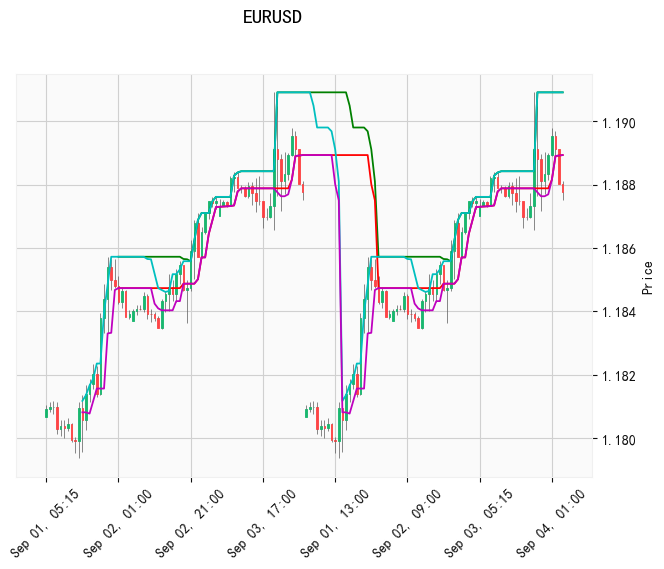

ERROR -1 2103 Market data farm connection is broken:usfuture
ERROR -1 2103 Market data farm connection is broken:usfuture
ERROR -1 2103 Market data farm connection is broken:usfuture
ERROR -1 2103 Market data farm connection is broken:usfuture
ERROR -1 2103 Market data farm connection is broken:usfuture


In [22]:
if ibapi.isConnected()==False:  
        # 此处需要注意有错误不能退出，不能让程序和市场处在断连的状态
        print (req_current_TWS_time()+"当前无TWS连接！尝试重新连接！")
        
        # 为了避免clientId被占用，启用随机数作为连接clientId
        clientId = np.random.randint(1,100) 
        ibapi = IBapi('127.0.0.1', 7497, clientId)
        time.sleep(1)
else:
    # 当前TWS时间 
    current_TWS_time=req_current_TWS_time()
    current_IDE_time=req_current_time()
    print('Current time is:', current_IDE_time)

    # 请求历史数据。一般情况下需要更长时间返回，给定3秒钟；其他请求可以酌情减少
    ibapi.reqHistoricalData(reqId=110, contract = eurusd_contract, endDateTime='', durationStr='3 D', \
                                barSizeSetting='1 hour', whatToShow='bid', useRTH = 1, formatDate=1, \
                                    keepUpToDate=False, chartOptions=[])
    time.sleep(3)
    print('Historical data is retrieved.')

    # 调用自定义函数存储历史数据
    df = ibapi.storehistoricalData()
#         df.to_csv('eurusd.csv') 

    # 计算唐奇安通道: df 数据；n 表示周期；name 表示在 df 中新的列名，用来存储唐奇安通道的上轨数值
    donchian_high(df,n1, 'donchian_up' )  
    donchian_low(df,n1, 'donchian_down' )  

    donchian_high(df, n3, 'donchian_up_n3')
    donchian_low(df,n3, 'donchian_down_n3' )  

    # 将原始数据以及计算好的唐奇安通道保存至文件
    df.to_excel("eurusd.xlsx")
    print ("数据获取完成！")

    # 行情及唐奇安通道可视化，亦可用于进出场位置标记
    if open_graph == True:  # 显示 n1, n2, n3 唐奇安通道
        add_plot = [
            mpf.make_addplot(df['donchian_up'], markersize = 8, color = 'g'),
            mpf.make_addplot(df['donchian_down'], markersize = 8, color = 'r'),
#                 mpf.make_addplot(df['donchian_up_n2'], markersize = 8, color = 'b'),
#                 mpf.make_addplot(df['donchian_up_n2'], markersize = 8, color = 'y'),
            mpf.make_addplot(df['donchian_up_n3'], markersize = 8, color = 'c'),
            mpf.make_addplot(df['donchian_down_n3'], markersize = 8, color = 'm'),
        ]
        title = 'EURUSD'
        style = mpf.make_mpf_style(base_mpf_style = 'yahoo', rc={'font.family': 'SimHei'})
       # try:
            # 画图。包含K线图，唐奇安通道，进出位置
        graph = mpf.plot(df, addplot = add_plot, title = title, ylabel = 'Price',\
                         type = 'candle', style = style, show_nontrading = False)
        #except:
         #   print('画图失败')

    time.sleep(57)  

In [23]:
# 程序持续运行，不需要断开连接
time.sleep(1)
print ("即将断开连接")    
ibapi.disconnect()

即将断开连接


## 任务5：下单

- main 函数的必要性
- 策略周期： 一小时执行一次，程序需要监视 → 时间运行的时间是一个固定的时间

### 设置程序执行时间

In [21]:
time_list = ["00:01","01:01","02:01","03:01","04:01","05:01",\
            "06:01","07:01","08:01","09:01","10:01","11:01",\
                "12:01","13:01","14:01","15:01","16:01","17:16"\
                    "18:01","19:01","20:01","21:01","22:01","23:01"]

- 以美东时间为基准的
    - 理论上，外汇市场是 24H 连续交易：周日下午5点 - 周五下午5点
    - 实际情况下，每天的下午5点 - 5:15，所有交易所都处于关盘的状态下
        - 选择`17:16` 越过流动性特别低的时候。

### 初始化及参数设置

In [22]:
# 定义唐奇安通道相关参数
n1 = 20
n3 = 10

# 是否进行 K线图可视化
open_graph = False

# 创建交易合约类
eurusd_contract = FX_Contract('EUR')

# 定义每次成交量 1 手
trading_volume_per_lot = 100000  # 标准手是：10W， 迷你手是 1W
number_of_lots = 1  # 手数
quantity = trading_volume_per_lot * number_of_lots

log_to_localfile('程序开始运行')  # 记录日志

### 条件判断 → 下单

- TWS 和 API 即使在同一个主机上，也有可能存在断连的情况 → 要考虑断连的情况
- 每次断连的时候，应该第一时间进行再次的连接
- 连接满足时，再进行：获取数据、条件判断、下单

In [23]:
clientId = np.random.randint(1,100) 
ibapi = IBapi('127.0.0.1', 7497, clientId)
time.sleep(0.5)

ERROR -1 2104 Market data farm connection is OK:usfarm.nj
ERROR -1 2104 Market data farm connection is OK:hfarm
ERROR -1 2103 Market data farm connection is broken:usfuture
ERROR -1 2104 Market data farm connection is OK:cashfarm
ERROR -1 2104 Market data farm connection is OK:usfarm
ERROR -1 2106 HMDS data farm connection is OK:euhmds
ERROR -1 2106 HMDS data farm connection is OK:cashhmds
ERROR -1 2106 HMDS data farm connection is OK:hkhmds
ERROR -1 2106 HMDS data farm connection is OK:fundfarm
ERROR -1 2106 HMDS data farm connection is OK:ushmds
ERROR -1 2158 Sec-def data farm connection is OK:secdefhk


In [25]:
while True:
    if ibapi.isConnected() == False:  # EClient 的函数 true if connection has been established, false if it has not. 
        # https://interactivebrokers.github.io/tws-api/classIBApi_1_1EClient.html#ab8e2702adca8f47228f9754f4963455d
        # 此处需要注意有错误不能退出，不能让程序和市场处在断连的状态   
        print(req_current_TWS_time()+'当前无 TWS 连接！尝试重新连接！')

        # 为了避免clientId被占用，启用随机数作为连接clientId
        clientId = np.random.randint(1, 100)
        ibapi = IBapi('127.0.0.1', 7497, clientId)
        time.sleep(0.5)
        continue  # 这里为什么要加 continue 呢？又没有循环
    else:
        print ("TWS 已经连接!")
        
        # 获得当前仓位情况
        ibapi.reqPositions()  # 这句代码还要单独执行么？后面调用 get_current 不会类内部自动运行么
        time.sleep(1)
        current_position = ibapi.get_current_position_in_df() # 这句代码还要单独执行么？后面调用 Find_Position 不会类内部自动运行么
        position = ibapi.Find_Position('DU4257965', 'EUR', 'CASH', 'USD' )
        
        # 当前TWS时间 
        current_TWS_time = req_current_TWS_time()
        current_IDE_time = req_current_time()
        print('Current time is:', current_IDE_time)

        # 请求历史数据。一般情况下需要更长时间返回，给定3秒钟；其他请求可以酌情减少
        
        if current_IDE_time in time_list:
            print('**当前时间：', current_IDE_time,'**')
            ibapi.reqHistoricalData(reqId=110, contract = eurusd_contract, endDateTime='', durationStr='3 D', \
                                        barSizeSetting='1 hour', whatToShow='bid', useRTH = 1, formatDate=1, \
                                            keepUpToDate=False, chartOptions=[])
            time.sleep(3)
            
            # 调用自定义函数存储历史数据
            df = ibapi.storehistoricalData()

            # 计算唐奇安通道: df 数据；n 表示周期；name 表示在 df 中新的列名，用来存储唐奇安通道的上轨数值
            donchian_high(df,n1, 'donchian_up' )  
            donchian_low(df,n1, 'donchian_down' )  
            donchian_high(df, n3, 'donchian_up_n3')
            donchian_low(df,n3, 'donchian_down_n3' )  

            # 将原始数据以及计算好的唐奇安通道保存至文件
            df.to_excel("EURUSD.xlsx")
            print ("数据获取完成！")
            
        # 仓位判断
        if position == 0:  # 无仓位时，满足条件则开仓
            
            if buy_condition():
                Place_Market_Order(eurusd_contract, 'buy', quantity)
                # 开仓之后避免同一分钟之内连续开仓，可加以控制
                # 只需要挺过100秒，则不再继续开仓
                # 此位置更加严格的写法是返回开仓成功以后再沉睡100秒，如不成功则需要人工干预
                # print (datetime.now().strftime("%H:%M")+"开多仓")
                log_to_localfile(req_current_time()+"开多仓")
                time.sleep(1)
            
            if sell_condition():
                Place_Market_Order(eurusd_contract, 'sell', quantity)
                # print (datetime.now().strftime("%H:%M")+"开空仓")
                log_to_localfile(req_current_time()+"开空仓")
                time.sleep(1)
                
        elif position > 0:  # 有做多仓位时，满足条件则平仓
            if close_buy_condition():
                Place_Market_Order(eurusd_contract, 'sell', quantity)
                log_to_localfile(req_current_time()+"多仓平仓")
                time.sleep(1)
            
        elif position < 0:  # 有做空仓位时，满足条件则平仓
            if close_buy_condition():
                    Place_Market_Order(eurusd_contract, 'buy', quantity)
                    # print (datetime.now().strftime("%H:%M")+"空仓平仓")
                    log_to_localfile(req_current_time()+"空仓平仓")
                    time.sleep(1)
                    
        time.sleep(60)  # 1 min 只需要下一次单，每一小时
        
    time.sleep(10)

TWS 已经连接!
Current time is: 14:23:16


NameError: name 'df' is not defined

ERROR -1 2103 Market data farm connection is broken:usfuture
ERROR -1 2103 Market data farm connection is broken:usfuture
ERROR -1 2103 Market data farm connection is broken:usfuture
ERROR -1 2103 Market data farm connection is broken:usfuture
ERROR -1 2103 Market data farm connection is broken:usfuture
ERROR -1 2103 Market data farm connection is broken:usfuture
ERROR -1 2103 Market data farm connection is broken:usfuture
ERROR -1 2103 Market data farm connection is broken:usfuture
ERROR -1 2103 Market data farm connection is broken:usfuture
ERROR -1 2103 Market data farm connection is broken:usfuture
ERROR -1 2103 Market data farm connection is broken:usfuture
ERROR -1 2103 Market data farm connection is broken:usfuture
ERROR -1 2103 Market data farm connection is broken:usfuture
ERROR -1 2103 Market data farm connection is broken:usfuture
ERROR -1 2103 Market data farm connection is broken:usfuture
ERROR -1 2103 Market data farm connection is broken:usfuture
ERROR -1 2103 Market dat

In [ ]:
# 程序持续运行，不需要断开连接
time.sleep(1)
print ("即将断开连接")    
ibapi.disconnect()